## Network activity simulations 

### Initialization

In [1]:
# Modules to import
# Note: due to some changes in Tgt cells and the way synaptic conductance variables are changed 
#           as well as how networks might vary, I chose not to write a class to run simulations on network activity 
#       additionally, the 'Setting up network' took a minute to finish, hence initializing a new 
#           instance of a class would take a while, hence I found it easier to do this 
# Network configuration file was created using MATLAB for Model N*
from __future__ import division
import numpy as np 
import matplotlib as mpl
from brian2 import *
from brian2.core.variables import *
import yaml
import matplotlib.pyplot as plt 
import time
import networkx as nx 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import FloatProgress
from IPython.display import display
from scipy import io as scio

In [2]:
# Equations and globals 

prefs.codegen.target = 'cython'

glob = {'dt': 0.05*ms, 'tstop': 200*ms}
const = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
         'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}


eqs_neuron = '''
    dv/dt = (1/C)*(k*(v-v_r)*(v-v_t)/mV - u + I_app + I_syn) : volt
    du/dt = int(1-is_fs)*a*(b*(v-v_r) - u) + int(is_fs)*a*(big_U-u): amp
    big_U = int(v>=v_b)*b*((v-v_b)**3)/(mV*mV) : amp
 
    I_app = i0*(t>=ti)*(t<=tf) + i_hold : amp
    I_syn = I_elec + I_AMPA + I_GABA : amp 

    I_elec : amp
    I_AMPA : amp 
    I_GABA : amp 
    C : farad
    v_r : volt
    v_t : volt
    v_p : volt
    k : amp/volt
    a : 1/second
    b : amp/volt
    c : volt
    d : amp
    is_fs : 1
    v_b : volt
    e_vpu : volt/amp
    e_cu : volt/amp
    e_du : amp
    i0 : amp 
    i_hold : amp
    ti : second
    tf : second

'''
eqs_AMPA = '''
    g_AMPA : siemens 
    I_AMPA_post = g_AMPA*(E_AMPA-v)*s_AMPA : amp (summed)
    ds_AMPA/dt = -s_AMPA/tau_AMPA : 1 (clock-driven) 
'''
eqs_pre_glut = '''
    s_AMPA += 1
'''
eqs_GABA = '''
    g_GABA : siemens 
    I_GABA_post = g_GABA*(E_GABA-v)*s_GABA : amp (summed)
    ds_GABA/dt = -s_GABA/tau_GABA : 1  (clock-driven) 
'''
eqs_pre_gaba = '''
    s_GABA += 1
'''
eqs_elec = '''
    g_elec:siemens
    I_elec_post = g_elec*(v_pre-v_post) : amp (summed)
'''

In [3]:
# Loading PARAMS + NETCON 
# Both Model Na and Model Nb have ID 'Net_3'
# Since this has N_unit = 50 
# Hence N = num_neurons = 50*3 = 150
# Creation of network configuration and adjacency matrix was done in MATLAB
# Refer to 'create_net_adj_mat.m' file
PRM_FILE = '../prm_files/prm.yaml'
NET_FILE = '../prm_files/extended_net_con.yaml'
NET_NAME = 'Net_3'

netgraph = yaml.load(open(NET_FILE))[NET_NAME]
param = yaml.load(open(PRM_FILE))
N = shape(netgraph['nodes'])[0]
cell_names = np.asarray(netgraph['nodes'])[:,0]
cell_types = np.asarray(netgraph['nodes'])[:,1]
connections = np.asarray(netgraph['edges'])

cell_dict = []
for it in cell_types: 
    cell_dict.append(param[it])
unit_dict = param['units']
init_vals = {} 
for k in cell_dict[0].iterkeys():
    init_vals[k] = [_cd[k] for _cd in cell_dict]  * eval(unit_dict[k])
init_states = init_vals 

In [4]:
# Necessary functions 
def indexOfCell(cell_names, cell_name2find):
    return np.where(np.array(cell_names) == cell_name2find)[0][0]

In [5]:
# Setting up network 
setup_startT = time.time()
G = NeuronGroup(N=N, model=eqs_neuron, threshold='v >= v_p + e_vpu*u',\
                reset='v = c + e_cu*u; u = (u+d)*(u+d<e_du) + e_du*(u+d>=e_du)', method='euler')
S_elec = Synapses(G, G, model=eqs_elec)
S_AMPA = Synapses(G, G, model=eqs_AMPA, on_pre=eqs_pre_glut, method='euler') 
S_GABA = Synapses(G, G, model=eqs_GABA, on_pre=eqs_pre_gaba, method='euler') 
for key in const.keys(): 
    val = float(const[key])
    dim = const[key].dim
    G.variables.add_constant(key, val, dim)
    S_elec.variables.add_constant(key, val, dim)
    S_AMPA.variables.add_constant(key, val, dim)
    S_GABA.variables.add_constant(key, val, dim)

non_zeros_conn = np.where(connections != '0')
for i,j in zip(*non_zeros_conn):
    conn_ij_raw = connections[i,j] 
    for conn_ij in conn_ij_raw.split('-'): 
        if conn_ij.upper() == 'ELEC': # SYMMETRICAL ELECTRICAL SYNAPSE 
            S_elec.connect(i=i,j=j)
            S_elec.connect(i=j,j=i)
        elif conn_ij.upper() == 'AMPA':
            S_AMPA.connect(i=i,j=j)
        elif conn_ij.upper() == 'GABA':
            S_GABA.connect(i=i,j=j)
        else:
            print "pair (%d, %d) - value = %s " %(i,j,conn_ij)
            raise ValueError('Cannot accept any other values representing '\
                             'synapses except "0", "ELEC", "AMPA" or "GABA"')
monitor = SpikeMonitor(G,record=True)
net = Network()
net.add(G, S_elec, S_AMPA, S_GABA, monitor)    

# this will save the initialized stage 
net.store('initialized')
setup_endT = time.time()
print('Total setup time = %.3f s' %(setup_endT-setup_startT))       

Total setup time = 60.396 s


### Testing one example 
Model Na and Model Nb are basically run with similar frameworks 

50 number of units - each unit comprises of 1 Src, 1 Int, 1 Tgt like Model 1a

$\sigma_{inp}$ : t_init_std

$G_{elec} = \frac{\Sigma G_{elec}}{N_{Int}} $ : (Int,ELEC,Int), g_elec_int_to_int*

$G_{GABA \rightarrow Int} = \frac{\Sigma G_{GABA \rightarrow Int}}{N_{Int}} $ : (Int,GABA,Int), g_GABA_Int2Int_total

Model Na : $\Sigma G_{GABA \rightarrow Int} = 0$

Model Nb : $\Sigma G_{GABA \rightarrow Int} \ne 0$

Refer to "Loading PARAMS + NETCON" in "Initialization" for more information on network configuration 

Running a single simulation took 3.42 s


(0, 150)

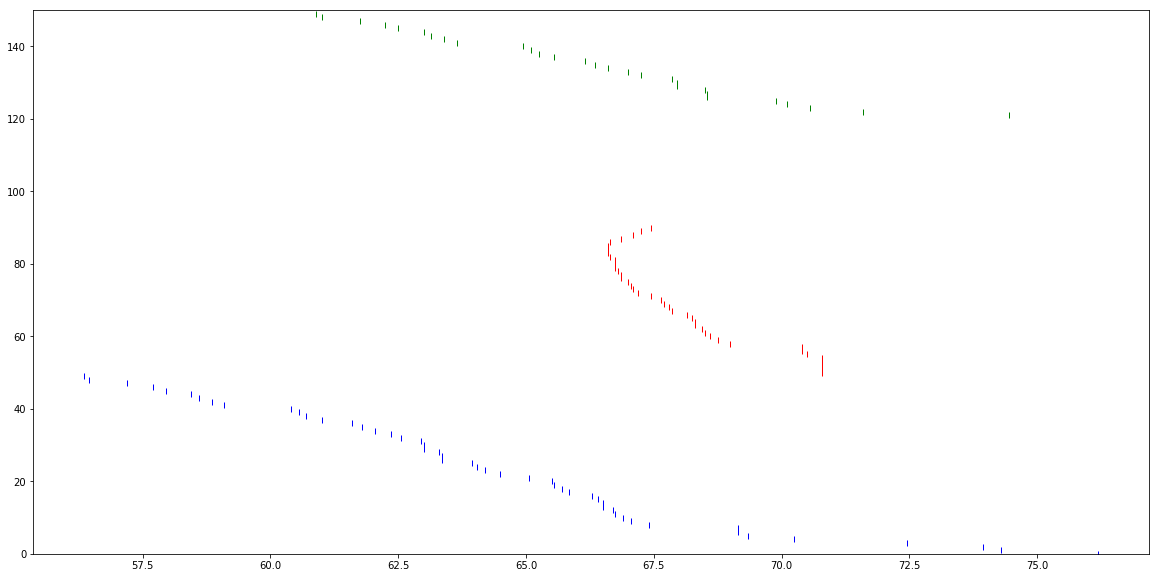

In [6]:
# Testing one simulation 

glob = {'dt': 0.05*ms, 'tstop': 200*ms}
startT = time.time() 

# this will not exactly look for labels 'Int', 'Tgt' nor 'Src' 
#       like in subthreshold simulations,
#       but instead will be used as template because 
# ** the labels are 'Int_1', 'Int_2', ...
# G_elec and G_GABA between Ints are normalized 
# Other types of synaptic conductances are not 
#       because, for example, only Src_1 -> Tgt_1,
#       while Src_1 does not -> Tgt_2
# note: the variable 'N' here does not represent number of units
#       it represents number of neurons 
#       hence number of units = N/3 = N_Int = N_Src = N_Tgt 
# the code was written before the names of the models were agreed upon
#       hence the tiny confusion 
syn = {('Int','ELEC','Int') : 5*nS/(N/3), 
       ('Src','AMPA','Tgt') : 20*nS,
       ('Src','AMPA','Int') : 5*nS,
       ('Int','GABA','Tgt') : 10*nS, 
       ('Int','GABA','Int') : 0*nS/(N/3)
        } 


# call the initialzed state again 
net.restore('initialized')

# now start changing the synaptic conductances accordingly  
# this might take some time 
# also, this is the stage where the actual network in mind matters
# hence, why I did not create a general class for this 
for c_s in syn.keys():
    if size(c_s) != 3 : 
        raise ValueError('Each "customed-synapse dict" key needs be a 3-element tuple '\
                         '("source_name", "synapse_type", "target_name")')
    for i in xrange(int(N/3)): 
        for j in xrange(int(N/3)): 
            if (c_s[0] == c_s[2] and i != j) or (c_s[0] != c_s[2] and i == j):
                src_loc = indexOfCell(cell_names,c_s[0] + '_%02d' %(i+1)) 
                tgt_loc = indexOfCell(cell_names,c_s[2] + '_%02d' %(j+1)) 
                val2replace = syn[c_s] 
                if c_s[1].upper() == 'ELEC': # SYMMETRICAL ELECTRICAL SYNAPSE 
                    S_elec.g_elec[S_elec.indices[src_loc,tgt_loc]] = val2replace 
                    S_elec.g_elec[S_elec.indices[tgt_loc,src_loc]] = val2replace
                elif c_s[1].upper() == 'AMPA':
                    S_AMPA.g_AMPA[S_AMPA.indices[src_loc,tgt_loc]] = val2replace
                elif c_s[1].upper() == 'GABA':
                    S_GABA.g_GABA[S_GABA.indices[src_loc,tgt_loc]] = val2replace
                else: 
                    raise ValueError('Cannot accept any other values like "%s" representing '\
                                     'synapses except "0", "ELEC", "AMPA" or "GABA"' %(c_s[1]))  

# 't_init_mean'around 50 to not collect data with t <0 
inp = {'t_init_mean': 50, 't_init_std' : 5, 't_duration': 20}

# initialize input to Src variables 
init_states['i0'] = np.zeros(N) * pA
init_states['ti'] = np.zeros(N) * ms
init_states['tf'] = np.zeros(N) * ms
init_states['i_hold'] = np.zeros(N) * pA

# generate a normal distribution of t_init_inp 
#        within 0 and (tstop - 100) = 100
#        centered around mean = 50

ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
while size(np.where(np.logical_and(ti_inp < 0, ti_inp > glob['tstop']/ms - 100))[0]) > 0:
    ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
td_inp = inp['t_duration']
saved_td_inp = [] 

for i in xrange(N): 
    c_n = cell_names[i]
    if 'Int' in c_n : 
        init_states['i_hold'][i] = 50*pA
    if 'Src' in c_n :
        if size(ti_inp) != 0:
            ti_i = ti_inp[-1]; ti_inp = ti_inp[:-1]
            saved_td_inp.append(ti_i)
            init_states['i0'][i] = 300*pA
            init_states['ti'][i] = ti_i*ms
            init_states['tf'][i] = (ti_i+td_inp)*ms
    if 'Tgt' in c_n : 
        # Tgt's Izhikevich model paramters were changed
        # to make it more excitable 
        init_states['i_hold'][i] = 10*pA
        init_states['v_t'][i] = -45*mV
        init_vals['C'][i] = 50*pF
G.set_states(init_states)
defaultclock.dt = glob['dt']
net.run(glob['tstop'])

endT = time.time() 
print("Running a single simulation took %.2f s" %(endT-startT))

# Test plot
t_v = monitor.t/ms
i_v = np.array(monitor.i)
%matplotlib inline
figure(figsize=(20,10))
prefixes = ['Src', 'Int', 'Tgt']
spkt = { pref : transpose([i for i in xrange(N) if pref in cell_names[i]]) \
        for pref in prefixes}
clrs = ['b','r','g']
cnt_ry = 0 
for i in xrange(len(prefixes)):
    pref = prefixes[i]
    for idx in spkt[pref]:    
        loc_ = np.where(i_v==idx)[0]     
        t_idx = t_v[loc_]
        plot(t_idx, np.ones(len(t_idx))*cnt_ry,'|',c=clrs[i])
        cnt_ry += 1
ylim([0,N])


### Simulating Model Na 
#### Variations of $\Sigma G_{elec}$ and $\sigma_{inp}$
50 trials of simulations each

In [ ]:
# Defining globals, constants and brian-prefs 
prefs.codegen.target = 'cython'

glob = {'dt': 0.05*ms, 'tstop': 200*ms}
const = {'E_AMPA' : 0*mV, 'E_GABA' : -80*mV, 
         'tau_AMPA' : 2*ms, 'tau_GABA' : 10*ms}

In [ ]:
# Setting up simulation parameters 

# Parameter vectors for variations 
num_trials = 50
n_trial_vec = np.array(xrange(num_trials))
t_init_std_vec = np.arange(1,11,1)
g_elec_int_to_int_vec = np.arange(0,5.5,0.5)

# This is to keep track of total number of simulations
#     to double check if all simulations were saved if needed 
num_dat = num_trials*len(t_init_std_vec)*len(g_elec_int_to_int_vec)

# This python dictionary will be saved as a struct in MATLAB
# Simulated spike times data and indices of neurons will be saved as 
#     a struct field of 'data2save' like 'dat_000001', which is also a struct
#     'dat_000001' is also a struct that has 3 fields 
#           'var' : 'var_tuple' -> what the varible combinations actually is 
#           'dat' : a struct of the simulated spike times 
#                 't_v' : all spike times 
#                 'idx_v' : index of the corresponding neuron 
#           'ti_inp' : the generated vector of ti_inp to Src of that trial 
# 'vars' contains variables, each of which is also a struct
#     'order' : where this is in the 'var_tuple'
#     'range' : the vector of variable
#     'unit' : (not really used but helpful if needed to check during analysis in MATLAB)
data2save = {'vars' : {'n_trial': {'order': 1, 'range': n_trial_vec, 'unit': 1}, 
                       't_init_std': {'order': 2, 'range': t_init_std_vec, 'unit': 'ms'}, 
                       'g_elec_int_to_int': {'order': 3, 'range': g_elec_int_to_int_vec, 'unit': 'nS'}},
             'cell_names' : tuple(cell_names), 
             'cell_types' : tuple(cell_types),
             'num_dat' : num_dat}

# The following lines mean: in each set of 'save_every' = 250 sequential simulations 
#     the file will be named 'extendedNet_withGJ_moredtvariations_<cnt_save current values>.mat'
#     like 'extendedNet_withGJ_moredtvariations_010.mat'
# In 'extendedNet_withGJ_moredtvariations_001.mat', for example, each of the 250 simulations
#     will be saved as a dictionary element (or struct filed in MATLAB)
#     as 'dat_000001', 'dat_000002', ... 'dat_000250'
# In 'extendedNet_withGJ_moredtvariations_002.mat', the struct fields/dictionary elements will be 
#     'dat_000251', 'dat_000252', ... 'dat_000500'
file_name_prefix = 'extendedNet_withGJ_moredtvariations' 
cnt_dat = 0                    
cnt_save = 0 
save_every = 250

# These are just to report on the progress of simulations and estimated time remaining
# 'min_elapsed' = 1: start reporting progress after 1 minute
# 'report_every'= 5: continue to report progress after every 5 minutes
min_elapsed = 1
report_every = 5

In [ ]:
# Running and saving simulation 

# Instantiate the progress bar 
fprogress = FloatProgress(min=0, max=num_dat) 
display(fprogress) # display the bar
fprogress.description = '%.0f %s' %(0,'%')

startT = time.time()

# The hard-coded part and where keeping track of the order of 
#      the 'var_tuple' is very important to do analysis afterwards 
# There is a way to parallelize this rather than a bunch of nested for-loops
#      but I didn't have much time left for the project so I ended up with this
# A suggestion for parallelizing this is to initialize the sets of 'var_tuple' first
#      then call it for each process. 
for g_elec_int_to_int_var in g_elec_int_to_int_vec: 
    for t_init_std_var in t_init_std_vec:           
        for n_trial_var in n_trial_vec: 
            
            # This is where most of the variations happen
            var_tuple = (n_trial_var, t_init_std_var, g_elec_int_to_int_var)

            syn = {('Int','ELEC','Int') : g_elec_int_to_int_var*nS/(N/3), 
                   ('Src','AMPA','Tgt') : 20*nS,
                   ('Src','AMPA','Int') : 5*nS,
                   ('Int','GABA','Tgt') : 10*nS, 
                   ('Int','GABA','Int') : 0*nS/(N/3)
                    } 
            inp = {'t_init_mean': 50, 't_init_std' : t_init_std_var, 't_duration': 20}

            # Calling the 'initalized' state of the network at the
            #     'Initialization/Setting up the network stage'
            net.restore('initialized')

            # Read in and change the variations 
            for c_s in syn.keys():
                if size(c_s) != 3 : 
                    raise ValueError('Each "customed-synapse dict" key needs be a 3-element tuple '\
                                     '("source_name", "synapse_type", "target_name")')
                for i in xrange(int(N/3)): 
                    for j in xrange(int(N/3)): 
                        if (c_s[0] == c_s[2] and i != j) or (c_s[0] != c_s[2] and i == j):
                            src_loc = indexOfCell(cell_names,c_s[0] + '_%02d' %(i+1)) 
                            tgt_loc = indexOfCell(cell_names,c_s[2] + '_%02d' %(j+1)) 
                            val2replace = syn[c_s] 
                            if c_s[1].upper() == 'ELEC': # SYMMETRICAL ELECTRICAL SYNAPSE 
                                S_elec.g_elec[S_elec.indices[src_loc,tgt_loc]] = val2replace 
                                S_elec.g_elec[S_elec.indices[tgt_loc,src_loc]] = val2replace
                            elif c_s[1].upper() == 'AMPA':
                                S_AMPA.g_AMPA[S_AMPA.indices[src_loc,tgt_loc]] = val2replace
                            elif c_s[1].upper() == 'GABA':
                                S_GABA.g_GABA[S_GABA.indices[src_loc,tgt_loc]] = val2replace
                            else: 
                                raise ValueError('Cannot accept any other values like "%s" representing '\
                                                 'synapses except "0", "ELEC", "AMPA" or "GABA"' %(c_s[1]))  
            # Input to Src
            init_states['i0'] = np.zeros(N) * pA
            init_states['ti'] = np.zeros(N) * ms
            init_states['tf'] = np.zeros(N) * ms
            init_states['i_hold'] = np.zeros(N) * pA

            ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
            while size(np.where(np.logical_and(ti_inp < 0, ti_inp > glob['tstop']/ms - 100))[0]) > 0:
                ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
            td_inp = inp['t_duration']
            saved_td_inp = [] 
            
            # Applying inputs to Src and neccessary holding currents, as well as change Tgt to make more excitable
            for i in xrange(N): 
                c_n = cell_names[i]
                if 'Int' in c_n : 
                    init_states['i_hold'][i] = 50*pA
                if 'Src' in c_n :
                    if size(ti_inp) != 0:
                        ti_i = ti_inp[-1]; ti_inp = ti_inp[:-1]
                        saved_td_inp.append(ti_i)
                        init_states['i0'][i] = 300*pA
                        init_states['ti'][i] = ti_i*ms
                        init_states['tf'][i] = (ti_i+td_inp)*ms
                if 'Tgt' in c_n : 
                    init_states['i_hold'][i] = 10*pA
                    init_states['v_t'][i] = -45*mV
                    init_vals['C'][i] = 50*pF
            G.set_states(init_states)
            defaultclock.dt = glob['dt']
            
            # Run the simulation 
            net.run(glob['tstop'])

            # Getting the data 
            t_v = monitor.t/ms
            idx_v = np.array(monitor.i)

            tmp_dict = {'var' : var_tuple, 
                        'dat' : {'t_v': t_v, 'idx_v' : idx_v}, 
                        'ti_inp' : saved_td_inp
                       }

            cnt_dat += 1 
            name_field = 'dat_%06d' %(cnt_dat)
            data2save[name_field] = tmp_dict
            
            # Reporting and saving the data chunks 
            fprogress.value += 1
            percent_complete = 100*(cnt_dat/num_dat)
            fprogress.description = '%.0f %s' %(percent_complete,'%')

            currT = time.time() 
            curr_elapsed = (currT - startT)/60
            if curr_elapsed >= min_elapsed and (np.round(curr_elapsed) % min_elapsed) == 0: 
                estTleft = 100*curr_elapsed/percent_complete - curr_elapsed
                print('%.2f min - %.0f %s progress, est. %.2f min left' %(curr_elapsed,percent_complete,'%',estTleft))
                min_elapsed += report_every

            if (cnt_dat > 0 and (cnt_dat % save_every) == 0) or cnt_dat == num_dat: 
                cnt_save += 1
                name_saved_file = '%s_%03d.mat' %(file_name_prefix, cnt_save)
                scio.savemat(name_saved_file, {'data2save' : data2save})
                print('\t + %s was saved' %(name_saved_file))
                del data2save
                
                # This needs to be exactly as the one in 'Setting up simulation parameters'
                # A better way to do this is just to create a function to easily call it 
                #        without the manual copy and paste 
                data2save = {'vars' : {'n_trial': {'order': 1, 'range': n_trial_vec, 'unit': 1}, 
                                       't_init_std': {'order': 2, 'range': t_init_std_vec, 'unit': 'ms'}, 
                                       'g_elec_int_to_int': {'order': 3, 'range': g_elec_int_to_int_vec, 'unit': 'nS'}},
                             'cell_names' : tuple(cell_names), 
                             'cell_types' : tuple(cell_types),
                             'num_dat' : num_dat}

endT = time.time()
print('Total time elapsed = %.3f m' %((endT-startT)/60))

### Simulating Model Nb
#### Variations of $\Sigma G_{elec}$ and $\sigma_{inp}$ with a presence of a fixed $\Sigma G_{GABA \rightarrow Int}$
50 trials of simulations each

Run each simulation by changing 'g_GABA_Int2Int_total' and 'file_name_prefix' accordingly 

In [ ]:
# Setting up simulation 
g_GABA_Int2Int_total = 1 # change to 3 or 5 for each run 
num_trials = 50
n_trial_vec = np.array(xrange(num_trials))
t_init_std_vec = np.arange(1,11,1)
g_elec_int_to_int_vec = np.arange(0,5.5,0.5)
num_dat = num_trials*len(t_init_std_vec)*len(g_elec_int_to_int_vec)
data2save = {'vars' : {'n_trial': {'order': 1, 'range': n_trial_vec, 'unit': 1}, 
                       't_init_std': {'order': 2, 'range': t_init_std_vec, 'unit': 'ms'}, 
                       'g_elec_int_to_int': {'order': 3, 'range': g_elec_int_to_int_vec, 'unit': 'nS'}},
             'cell_names' : tuple(cell_names), 
             'cell_types' : tuple(cell_types),
             'num_dat' : num_dat}
file_name_prefix = 'extendedNet_withGJandGABA=%01dnS' %(g_GABA_Int2Int_total)
cnt_dat = 0 
cnt_save = 0 
save_every = 250
min_elapsed = 1
report_every = 5

In [ ]:
# Running and saving simulation 
fprogress = FloatProgress(min=0, max=num_dat) # instantiate the bar
display(fprogress) # display the bar
fprogress.description = '%.0f %s' %(0,'%')

startT = time.time()
for g_elec_int_to_int_var in g_elec_int_to_int_vec: 
    for t_init_std_var in t_init_std_vec:           
        for n_trial_var in n_trial_vec: 
            var_tuple = (n_trial_var, t_init_std_var, g_elec_int_to_int_var)

            syn = {('Int','ELEC','Int') : g_elec_int_to_int_var*nS/(N/3), 
                   ('Src','AMPA','Tgt') : 20*nS,
                   ('Src','AMPA','Int') : 5*nS,
                   ('Int','GABA','Tgt') : 10*nS, 
                   ('Int','GABA','Int') : g_GABA_Int2Int_total*nS/(N/3)
                    } 
            inp = {'t_init_mean': 50, 't_init_std' : t_init_std_var, 't_duration': 20}

            net.restore('initialized')

            for c_s in syn.keys():
                if size(c_s) != 3 : 
                    raise ValueError('Each "customed-synapse dict" key needs be a 3-element tuple '\
                                     '("source_name", "synapse_type", "target_name")')
                for i in xrange(int(N/3)): 
                    for j in xrange(int(N/3)): 
                        if (c_s[0] == c_s[2] and i != j) or (c_s[0] != c_s[2] and i == j):
                            src_loc = indexOfCell(cell_names,c_s[0] + '_%02d' %(i+1)) 
                            tgt_loc = indexOfCell(cell_names,c_s[2] + '_%02d' %(j+1)) 
                            val2replace = syn[c_s] 
                            if c_s[1].upper() == 'ELEC': # SYMMETRICAL ELECTRICAL SYNAPSE 
                                S_elec.g_elec[S_elec.indices[src_loc,tgt_loc]] = val2replace 
                                S_elec.g_elec[S_elec.indices[tgt_loc,src_loc]] = val2replace # redundant 
                            elif c_s[1].upper() == 'AMPA':
                                S_AMPA.g_AMPA[S_AMPA.indices[src_loc,tgt_loc]] = val2replace
                            elif c_s[1].upper() == 'GABA':
                                S_GABA.g_GABA[S_GABA.indices[src_loc,tgt_loc]] = val2replace
                            else: 
                                raise ValueError('Cannot accept any other values like "%s" representing '\
                                                 'synapses except "0", "ELEC", "AMPA" or "GABA"' %(c_s[1]))  

            init_states['i0'] = np.zeros(N) * pA
            init_states['ti'] = np.zeros(N) * ms
            init_states['tf'] = np.zeros(N) * ms
            init_states['i_hold'] = np.zeros(N) * pA

            ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
            while size(np.where(np.logical_and(ti_inp < 0, ti_inp > glob['tstop']/ms - 100))[0]) > 0:
                ti_inp = np.sort(np.random.normal(inp['t_init_mean'],inp['t_init_std'],int(N/3)+1))
            td_inp = inp['t_duration']
            saved_td_inp = [] 

            for i in xrange(N): 
                c_n = cell_names[i]
                if 'Int' in c_n : 
                    init_states['i_hold'][i] = 50*pA
                if 'Src' in c_n :
                    if size(ti_inp) != 0:
                        ti_i = ti_inp[-1]; ti_inp = ti_inp[:-1]
                        saved_td_inp.append(ti_i)
                        init_states['i0'][i] = 300*pA
                        init_states['ti'][i] = ti_i*ms
                        init_states['tf'][i] = (ti_i+td_inp)*ms
                if 'Tgt' in c_n : 
                    init_states['i_hold'][i] = 10*pA
                    init_states['v_t'][i] = -45*mV
                    init_vals['C'][i] = 50*pF
            G.set_states(init_states)
            defaultclock.dt = glob['dt']
            net.run(glob['tstop'])

            t_v = monitor.t/ms
            idx_v = np.array(monitor.i)

            tmp_dict = {'var' : var_tuple, 
                        'dat' : {'t_v': t_v, 'idx_v' : idx_v}, 
                        'ti_inp' : saved_td_inp
                       }

            cnt_dat += 1 
            name_field = 'dat_%06d' %(cnt_dat)
            data2save[name_field] = tmp_dict
            fprogress.value += 1
            percent_complete = 100*(cnt_dat/num_dat)
            fprogress.description = '%.0f %s' %(percent_complete,'%')

            currT = time.time() 
            curr_elapsed = (currT - startT)/60
            if curr_elapsed >= min_elapsed and (np.round(curr_elapsed) % min_elapsed) == 0: 
                estTleft = 100*curr_elapsed/percent_complete - curr_elapsed
                print('%.2f min - %.0f %s progress, est. %.2f min left' %(curr_elapsed,percent_complete,'%',estTleft))
                min_elapsed += report_every

            if (cnt_dat > 0 and (cnt_dat % save_every) == 0) or cnt_dat == num_dat: 
                cnt_save += 1
                name_saved_file = '%s_%03d.mat' %(file_name_prefix, cnt_save)
                scio.savemat(name_saved_file, {'data2save' : data2save})
                print('\t + %s was saved' %(name_saved_file))
                del data2save

                data2save = {'vars' : {'n_trial': {'order': 1, 'range': n_trial_vec, 'unit': 1}, 
                                       't_init_std': {'order': 2, 'range': t_init_std_vec, 'unit': 'ms'}, 
                                       'g_elec_int_to_int': {'order': 3, 'range': g_elec_int_to_int_vec, 'unit': 'nS'}},
                             'cell_names' : tuple(cell_names), 
                             'cell_types' : tuple(cell_types),
                             'num_dat' : num_dat}

endT = time.time()
print('Total time elapsed = %.3f m' %((endT-startT)/60))